## Лабораторная работа 1 по дисциплине "Машинное обучение"

Мной был выбран датасет с данными о пассажирах Титаника. Датасет содержит данные о классе пассажира, имени, поле, возрасте и прочих параметрах. Целевая переменная в данном случае - был ли пассажир спасен.

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import *
from sklearn.naive_bayes import *
import matplotlib.pyplot as plt

In [7]:
data_frame = pd.read_csv("https://raw.githubusercontent.com/ilya89099/ML1/master/titanic.csv")
data_frame = data_frame.drop_duplicates()

Проверим, есть ли пропуски в данных

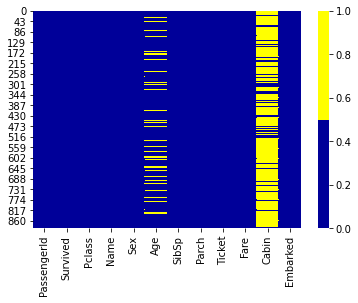

In [8]:
colors = ['#000099','#ffff00']
sns.heatmap(data_frame[data_frame.columns[:]].isna(),cmap = sns.color_palette(colors))
plt.show()

In [13]:
for label in ["Age", "Cabin"]:
    print("{} NA % : {}".format(label, data_frame[label].isnull().sum() * 100 / len(data_frame)))

Age NA % : 19.865319865319865
Cabin NA % : 77.10437710437711


Заметно, что 77% процентов значений в колонке Cabin отсутствуют. Без какой-либо дополнительной информации вряд ли получится извлечь из этого признака полезную информацию

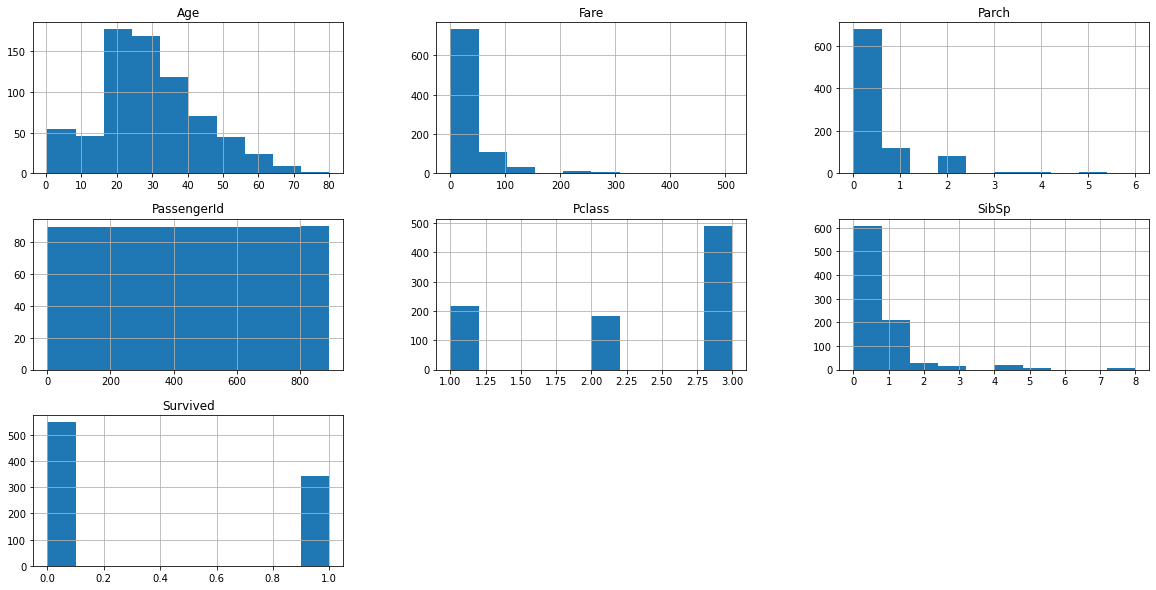

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

In [14]:
features = list(set(data_frame.columns))
data_frame[features].hist(figsize=(20,10))
plt.show()


print(data_frame.head())
print(data_frame.describe(include="all"))

Как видно, в датасете есть несколько категориальных признаков. Для работы с ними, их нужно преобразовать

In [15]:
data_frame = data_frame[data_frame["Embarked"].notna()]
data_frame = data_frame.drop(labels=["Name", "Ticket", "Cabin", "PassengerId"], axis=1)

OH_cols = pd.DataFrame(OneHotEncoder(handle_unknown="ignore", sparse=False).fit_transform(data_frame[["Embarked"]]),
                       columns=["Embarked_1", "Embarked_2", "Embarked_3"])
OH_cols.index = data_frame.index

data_frame = pd.concat([data_frame.drop(labels=["Embarked"], axis=1), OH_cols], axis=1)

data_frame["Sex"] = LabelEncoder().fit_transform(data_frame["Sex"])
data_frame["Age"] = data_frame["Age"].fillna(data_frame["Age"].median())


Убираем некоторые параметры и кодируем оставшиеся категориальные признаки(пол через LabelEncoder, так как он бинарный, Embarked имеет три возможных значения, так что здесь подойдет OneHotEncoder). Недостающие значения признака возраст можно заменить медианным значением

In [16]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(data_frame.drop("Survived", axis=1)))
y = data_frame["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Изменяем масштаб признаков с помощью StandardScaler и разделяем выборку на обучающую и тестовую

Теперь можно реализовать алгоритм K ближайших соседей

Для начала, несколько метрик

In [18]:
def p_r_setup(y_predicted, y_test):
    TN, TP, FN, FP = 0, 0, 0, 0
    for p, y in zip(y_predicted, y_test):
        if p and y:
            TP += 1
        elif p and not y:
            FP += 1
        elif not p and y:
            FN += 1
        elif not y and not p:
            TN += 1
    return TN, TP, FN, FP

def precision(y_predicted, y_test):
    TN, TP, FN, FP = p_r_setup(y_predicted, y_test)
    return TP / (TP + FP)

def recall(y_predicted, y_test):
    TN, TP, FN, FP = p_r_setup(y_predicted, y_test)
    return TP / (TP + FN)

def get_minkovski_metric(k):
    if (k == float("inf")):
        return lambda a,b: np.max(np.abs(a - b))

    return lambda a, b: np.power(np.sum(np.power(np.abs(a - b), k)), 1/k)

def euclidean(a, b):
    return np.sqrt(np.sum(np.square(a - b)))

И сам алгоритм. Настраиваемые параметры - количество соседей и метрика расстояния. Алгоритм учитывает расстояния до соседей при предсказании.

In [22]:
class KNN:
    def __init__(self, n_neighbors=5, metric=euclidean):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit_predict(self, X_train, y_train, X_test):
        self.fit(X_train, y_train)
        return self.predict(X_test)

    def fit(self, X,y):
        self.X = X.to_numpy()
        self.y = y.to_numpy()

    def predict(self, X):
        X_arr = X.to_numpy()
        labels = []
        for X_row in X_arr:
            distance = []
            for l_row, cls in zip(self.X, self.y):
                distance.append((self.metric(X_row, l_row), cls))
            distance = sorted(distance)[:self.n_neighbors]
            if distance[0][0] == 0:
                labels.append(distance[0][1])
                continue
            weighed_classes = {}
            for dist, cls in distance:
                if cls not in weighed_classes:
                    weighed_classes[cls] = 0
                weighed_classes[cls] += 1 / dist
            labels.append(max(weighed_classes.items(), key=lambda kv:kv[1])[0])
        return pd.Series(labels, index=X.index)


Теперь можно сравнить свою реализацию с библиотечной

In [20]:
def print_score(model_name, y_predicted, y_test):
    print("{} score:\naccuracy: {}, precision: {}, recall {}".format(model_name,
                                                                     accuracy_score(y_predicted, y_test),
                                                                     precision(y_predicted, y_test),
                                                                     recall(y_predicted, y_test)))

In [23]:
knn = KNN()
knn.fit(X_train, y_train)
print_score("My KNN", knn.predict(X_test), y_test)

sklearn_knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
sklearn_knn.fit(X_train, y_train)
print_score("Sklearn KNN", sklearn_knn.predict(X_test), y_test)

My KNN score:
accuracy: 0.7078651685393258, precision: 0.6615384615384615, recall 0.589041095890411
Sklearn KNN score:
accuracy: 0.7078651685393258, precision: 0.6615384615384615, recall 0.589041095890411


Попробуем варьировать параметр n_neighbours

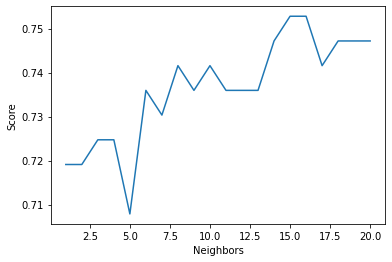

In [24]:
k = list(range(1,21))
scores = []
for cur_k in k:
    knn = KNN(n_neighbors=cur_k)
    knn.fit(X_train, y_train)
    scores.append(accuracy_score(y_test, knn.predict(X_test)))

plt.plot(k, scores)
plt.xlabel("Neighbors")
plt.ylabel("Score")

plt.show()

In [25]:
index = np.argmax(scores)
print("Max accuracy = {} at {} neighbors".format(scores[index], k[index]))
argmax_neighbors = k[index]

Max accuracy = 0.7528089887640449 at 15 neighbors


Также можно использовать различные метрики, протестируем метрики Минковского с различными параметрами

In [26]:
for i in [1, 2, 3, 4, 5, float("inf")]:
    knn = KNN(n_neighbors=argmax_neighbors, metric=get_minkovski_metric(i))
    knn.fit(X_train, y_train)
    print("Minkovski metric, p = {}: {}".format(i, accuracy_score(knn.predict(X_test), y_test)))

Minkovski metric, p = 1: 0.7471910112359551
Minkovski metric, p = 2: 0.7528089887640449
Minkovski metric, p = 3: 0.7528089887640449
Minkovski metric, p = 4: 0.7528089887640449
Minkovski metric, p = 5: 0.7528089887640449
Minkovski metric, p = inf: 0.7359550561797753


Реализуем Байесовский классификатор с распределением Гаусса

In [28]:
class NBayes():
    
    @staticmethod
    def __split_X__(X, y):
        class_rows = {}
        for row, cls in zip(X, y):
            if cls not in class_rows:
                class_rows[cls] = list()
            class_rows[cls].append(row)
        return class_rows


    @staticmethod
    def __prob_chars__(X):
        means = np.mean(X, axis=0)
        stds = np.std(X, axis=0)
        return list(zip(means, stds))

    @staticmethod
    def __Gauss_prob__(x, mean, std):
        return (1 / np.sqrt(2 * np.pi * np.square(std))) * np.exp(-np.square(x - mean) / (2 * np.square(std)))

    def fit(self, X, y):
        X = X.to_numpy()
        y = y.to_numpy()
        class_rows = NBayes.__split_X__(X, y)
        self.cls_labels = np.unique(y)
        self.chars_by_class = {cls: NBayes.__prob_chars__(rows) for cls, rows in class_rows.items()}
        self.prob_by_class = {cls: len(rows) / len(X) for cls, rows in class_rows.items()}

    def predict(self, X):
        X = X.to_numpy()
        y = []
        for row_to_predict in X:
            result_probs = {}
            for cls in self.cls_labels:
                result_probs[cls] = self.prob_by_class[cls] \
                                    * np.prod([NBayes.__Gauss_prob__(row_to_predict[i], mean, std) for i, (mean, std) in enumerate(self.chars_by_class[cls])])
            y.append(max(result_probs.items(), key=lambda kv: kv[1])[0])
        return y


    def fit_predict(self, X_train, y_train, X_test):
        self.fit(X_train, y_train)
        return self.predict(X_test)

Сравнение с реализацией из sklearn

In [30]:
bayes = NBayes()
bayes.fit(X_train, y_train)
print_score("My Bayes", bayes.predict(X_test), y_test)


sklearn_bayes = GaussianNB()
sklearn_bayes.fit(X_train, y_train)
print_score("Sklearn Bayes", sklearn_bayes.predict(X_test), y_test)

My Bayes score:
accuracy: 0.7303370786516854, precision: 0.6865671641791045, recall 0.6301369863013698
Sklearn Bayes score:
accuracy: 0.7303370786516854, precision: 0.6865671641791045, recall 0.6301369863013698
